In [73]:
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
from Bio import SeqIO, SeqUtils
from Bio.SeqRecord import SeqRecord
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter

def read_fasta(
    fasta_path: Path, translate_to_protein: bool = False
) -> List[SeqRecord]:
    """Given a fasta file, obtain its DNA sequences or translated protein sequences.
    Parameters
    ----------
    fasta_path : Path
        Path to access the fasta sequences.
    translate_to_protein : bool, optional
        Whether to translate the DNA sequences to protein sequneces, by default False.
    Returns
    -------
    List[SeqRecord]
        DNA or protein sequences from the fasta file.
    """
    seqs = list(SeqIO.parse(fasta_path, "fasta"))
    if translate_to_protein:
        prot_seqs = []
        for seq in seqs:
            prot_seq = seq.translate(to_stop=True)
            prot_seq.id = seq.id
            prot_seq.name = seq.name
            prot_seq.description = seq.description
            prot_seq.dbxrefs = seq.dbxrefs
            prot_seqs.append(prot_seq)
        seqs = prot_seqs
        #seqs = [seq.translate(to_stop=True) for seq in seqs]
    return seqs

def gc_content(seqs: List[SeqRecord]) -> List[float]:
    """Given a list of DNA sequences, return each sequence's GC content.
    Parameters
    ----------
    seqs : List[SeqRecord.SeqRecord[str]]
        A list of DNA sequences.
    Returns
    -------
    List
        GC content of each DNA sequence.
    """
    return [SeqUtils.GC(rec.seq) for rec in seqs]

In [74]:
# Write an amino acid sequence file
seqs = read_fasta("/home/couchbucks/Documents/saketh/cpe/data/datasets/mdh/mdh_natural_dataset.fasta", translate_to_protein=True)
SeqIO.write(seqs, "full_mdh_amino_acid.fasta", "fasta")

KeyboardInterrupt: 

In [75]:
# Read nucleotide sequences
seqs = read_fasta("/home/couchbucks/Documents/saketh/cpe/data/datasets/mdh/mdh_natural_dataset.fasta")

In [76]:
print(len(seqs))

36631


In [78]:
embeddings = np.load("/home/couchbucks/Documents/saketh/cpe/cpe/embeddings/bert_330m/bert_330m_codon_wordlevel.npy")
#avg_embeddings = np.load("/home/couchbucks/Documents/saketh/cpe/cpe/embeddings/bert_3m_codon_wordlevel_mdh_embeddings.npy")

MemoryError: Unable to allocate 92.8 GiB for an array with shape (24906735616,) and data type float32

In [61]:
embeddings.shape

(36631, 1024, 240)

In [62]:
embeddings.shape, len(seqs), avg_embeddings.shape

((36631, 1024, 240), 36631, (36631, 240))

In [6]:
np.save("averaged_full_mdh_fasta-train_folder_concatenated.npy", avg_embeddings)

In [63]:
gc = gc_content(seqs)

/home/couchbucks/Documents/saketh/cpe/env/lib/python3.10/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


array([[<Axes: title={'center': '0'}>]], dtype=object)

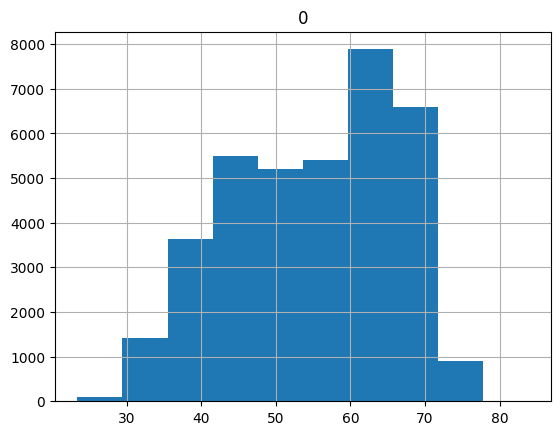

In [9]:
pd.DataFrame(gc).hist()

In [50]:
#tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)

ValueError: Found array with dim 3. TSNE expected <= 2.

In [64]:
X_tsne = TSNE(learning_rate="auto", init="pca").fit_transform(avg_embeddings)

In [65]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(avg_embeddings)

<Axes: title={'center': 'PCA MDH Averaged Embeddings - Codon Wordlevel'}, xlabel='z0', ylabel='z1'>

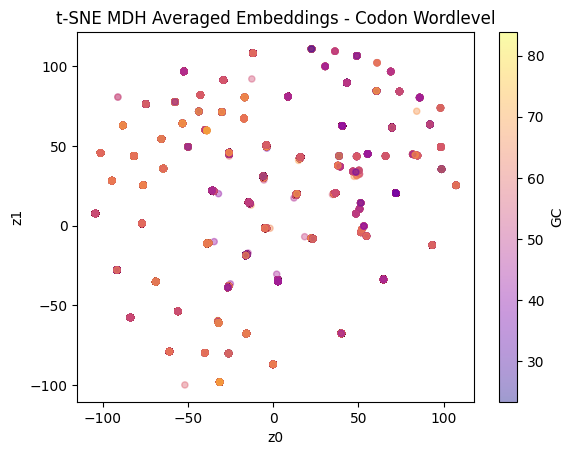

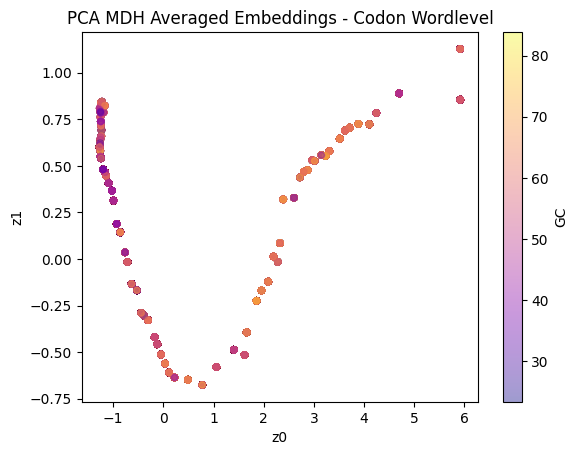

In [66]:
# create new dataframe for the subplot
df = pd.DataFrame(
    {
        "z0": X_tsne[:, 0],
        "z1": X_tsne[:, 1],
        "GC": gc,
    }
)

df.plot.scatter(x="z0", y="z1", c="GC", colormap="plasma", alpha=0.4, title="t-SNE MDH Averaged Embeddings - Codon Wordlevel")


df = pd.DataFrame(
    {
        "z0": X_pca[:, 0],
        "z1": X_pca[:, 1],
        "GC": gc,
    }
)
df.plot.scatter(x="z0", y="z1", c="GC", colormap="plasma", alpha=0.4, title="PCA MDH Averaged Embeddings - Codon Wordlevel")

In [67]:
# Predicting GC content from averaged embeddings
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(avg_embeddings, gc, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

In [68]:
print("Train R^2:", regr.score(X_train, y_train))
print("Test R^2:", regr.score(X_test, y_test))

Train R^2: 0.1636901996981458
Test R^2: 0.17337259542694217


In [56]:
# Predicting secondary structure

def preprocess_secondary_structure(
    input_dir: str, seqs: List[SeqRecord], embeds: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    ss_seqs = []
    unique_vals = set()
    embed_subset = []
    for idx, seq in enumerate(seqs):
        label_file = Path(input_dir) / f"{seq.id}.ss2"
        if label_file.exists():
            lines = Path(label_file).read_text().rstrip().split("\n")[2:]
            ss = [line.split()[2] for line in lines]
            ss_seqs.extend(ss)
            unique_vals.update(set(ss))
            embed_subset.extend(embeds[idx, :len(ss), :]) # May be a bug here if ss != seq length


    print(f"Found a total of {len(ss_seqs)} input residues")
    assert len(ss_seqs) == len(embed_subset)

    val_map = {v: i for i, v in enumerate(sorted(unique_vals))}

    labels = np.array([val_map[v] for v in ss_seqs]) # integer labels
    features = np.array(embed_subset)
    
    assert len(labels) == len(features)
    
    return features, labels


In [5]:
features, labels = preprocess_secondary_structure("s4pred/preds/", seqs, embeddings)

Found a total of 1609340 input residues


In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=1, train_size=10_000, test_size=10_000)
clf = SVC(verbose=True, random_state=1)
clf.fit(X_train, y_train)

print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

[LibSVM]..*
optimization finished, #iter = 2913
obj = -2526.758482, rho = -0.618287
nSV = 3058, nBSV = 2705
...
*.*
optimization finished, #iter = 4377
obj = -4856.100200, rho = -0.832809
nSV = 5695, nBSV = 5324
..*
optimization finished, #iter = 2806
obj = -2328.411004, rho = 0.014929
nSV = 2878, nBSV = 2538
Total nSV = 7747
Train Accuracy: 0.7313
Test Accuracy: 0.6866


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=1, train_size=100_000, test_size=10_000)
clf = LogisticRegression(verbose=True, random_state=1)
clf.fit(X_train, y_train)

print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1539     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09861D+05    |proj g|=  8.41687D+04

At iterate   50    f=  7.11340D+04    |proj g|=  5.61424D+03

At iterate  100    f=  6.82302D+04    |proj g|=  3.52295D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1539    100    117      1     0     0   3.523D+02   6.823D+04
  F =   68230.176175205474     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/lambda_stor/homes/abrace/src/genslm-generator/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


Train Accuracy: 0.71381
Test Accuracy: 0.7074


In [ ]:
X_tsne = TSNE(learning_rate="auto", init="pca", verbose=True).fit_transform(X_train[::100])

df = pd.DataFrame(
    {
        "z0": X_tsne[:, 0],
        "z1": X_tsne[:, 1],
        "SS": y_train[::100],
    }
)
df.plot.scatter(x="z0", y="z1", c="SS", colormap="viridis", alpha=0.4, title="t-SNE MDH Residue Embeddings")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.713896


/lambda_stor/homes/abrace/src/genslm-generator/env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.405540


In [ ]:
'''
Codon Wordlevel 3m NeoX

Prediction: ATGAAAGTTCCCGTTCGCGTCGCCGTCACCGGCGCCGCCGGCCAGATCGGCTACAGCCTCGCCTTCCGCATCGCCGCCGGCGACCTGCTGGGCCCGGACCAGCCGGTCATCCTGCAGCTGATCGAGATCCCGCCGGCCATGGGCGCCCTGAAGGGCGTGGTGATGGAACTCGACGACTGCGCCTTCCCGCTGCTCGCCGGCATCGTCGCCACCGACGACATGGACGAAGGCTTCAAGGGCGCCGACTGGGCCCTGCTGGTCGGCGCCATGCCGCGCGGCCCGGGCATGGAGCGCGCCGACCTGCTGAAGGCCAACGGCAAGATCTTCGGCCCGCAGGGCAAGGCCCTGGCCGACGTCGCCGCCCGCGACGTCAAGGTGCTGGTGGTCGGCAACCCGGCCAACACCAACGCCCTGATCGCCCAGGCCAACGCCCCGGACCTGGACGCCCGCAACTTCACCGCCATGACCCGCCTGGACCACAACCGCGCCCTGTCGCAGCTGGCCGCCAAGACCGGCACCCACCACACCGACATCAAGAACATGACCATCTGGGGCAACCACTCCGCCACCCAGTACCCGGACATCCACCACGCCCTGGTCGACGGCCGCCCGGCCCTGGACCTGGTCGACCAGGCCTGGTACGAGAACGACTTCATCCCGACCGTGCAGCAGCGCGGCGCCGCCATCATCAAGGCCCGCGGCGCCTCCTCGGCCGCCTCGGCCGCCAGCGCCGCCATCGACCACATGCGCGACTGGGCGCTGGGCACCGCCGGCCGCGACTGGGTCTCGATGGGCGTGCCGTCCGACGGCTCCTACGGCATCGCCCCGGGCGTGATCTACTCCTACCCGTGCACCTGCAAGAACGGCCAGTACAAGATCGTCCAGGGCCTCGAGATCAGCGACTTCTCCCGCGGCCGCATGGACGCCACCGCCAAGGAACTGCGCGAAGAGCGCGACGCGGTCCAGGACCTGCTGGGC
Acc gtruth: ATGAAAGAACCCGTGCGCATCGCCATTACCGGCGCGGCCGGCCAGATCGGCTACCAGCTGTGCTTCCGCATCGCCTCCGGCGGCATGTTCGGCCCCAACCAGCCGGTCATCCTGCAGCTGCTCGAGATTCCGCCGGCCATCGATGCGCTCAAGGGCGTGGTCATGGAACTGGAAGACGCCGCGTTCCCGCTGCTGCACGGCATCGTCGCCACCACCGAGCTGGACGAAGGTTTCAAGGACACCGACTTCGCCATCCTGGTCGGCGCCAAGCCGCGCGGCCCGGGCATGGAACGCGCTGACCTGCTGGCCGAGAACGGCAAGATCTTCGGCCCGCAGGGCAAGAGCCTCAACGCCGTGGCCAGCCGCGACGTCAAGGTACTGGTGGTCGGCAACCCGGCCAATACCAATGCCCTGATCGCCCAGGCCAACGCTCCGGACCTGCCGCCGGAAAACTTCACCGCCATGACCCGCCTCGATCACAATCGCGCGCTGGCACAACTGGCCGAAAAGACCGGCCAGCATCACTCGCTGATCAAGCAGATGATCATCTGGGGCAACCACTCCTCGACCCAGTACCCGGACCTGCATCACACGCTGGTTGGCGGTCAGCCGGCACTCGACAAGATCGACCAGGACTGGTACGAGAGCACCTTCATCCCCACGGTGCAGCAGCGCGGTGCGGCAATCATCAAGGCGCGCGGCGCCTCGAGTGCGGCCAGTGCGGCCAGTGCGGCCATCGACCACATCCGCGACTGGGCCCTGGGCACCGACGGTGACGACTGGGTATCCATGGCCGTGCCGTCCGATGGTAGCTATGGCATTGAACCGGGCGTAATCTACTCGTTCCCCTGCACTTGCGAGAACGGTTCCTGGAAGATCGTTCAGGGACTTGAAATCAATGATTTTTCAAGAACAAGAATGGACGCGACCGACAAGGAACTGCGCGAGGAGCGCGAGGCGGTGAAGGAACTGCTGTGA
'''

In [ ]:
'''
Codon Wordlevel 33m NeoX

Prediction: ATGAAAGTTCCCGTTCGCATTGCCATTACCGGCGCGGCCGGCCAGATCAGCTACCAGCTGTGCTTCCGCATCGCCTCCGGCGGCATGTTCGGGCCGAACCAGCCGGTCATCCTGCAGCTGCTGGAAATTCCCCCGGCCATCGACGCGCTGAAGGGCGTGGTCATGGAGCTGGACGACGCCGCCTTCCCGCTGCTGCACGGCGTGGTCGCCACCACCGAGATGGACGAGGGCTTCAAGGACACCGACTACGCCATGCTGGTCGGCGCCAAGCCGCGCGGCCCCGGCATGGAACGGGCCGACCTGCTGAGCGAGAACGGCAAGATCTTCGGCCCGCAGGGCAAGAGCCTCAACGCCGTGGCCAGCCGCGACGTCAAGGTCCTGGTCGTCGGCAACCCGGCCAACACCAACGCCCTGATCGCCCAGGCCAACGCCCCGGACCTGCCGCAGGAAAACTTCACCGCCATGACCCGCCTGGACCACAACCGCGCCCTGGCGCAGCTGGCCGGCAAGACCGGCATCCACCACACCCTGGTCAAGCAGATGATCATCTGGGGCAACCACTCCTCGACCCAGTACCCGGACCTGCACCACACCCTGGTCGCCGGCCAGCCGGCCCTCGACGGCGTCGACCAGGACTGGTACGAAAACGACTTCATCCCCACCGTGCAGCAGCGCGGCGCGGCGATCATCAAGGCCCGCGGCGCCTCCTCGGCGGCCTCGGCGGCCAGTGCCGCCATCGACCACATCCGCGACTGGGCGCTGGGCACCAACGGCGACGACTGGGTGTCCATGGCCGTGCCGTCCGACGGCAGCTACGGCATCGCCCCGGGCGTGATCCCCTCCTTCCCCTGCACCTGCGCCGACGGCGCCTGGAAGATCGTCCAGGGCCTGCCGGTCAACGATTTCTCCCGCGCGCGCATGGATGCCACCGACAAGGAACTGCGCGAAGAACGCGAAGCGGTGGAGGCACTGCTCTAA
Acc gtruth: ATGAAAGAACCCGTGCGCATCGCCATTACCGGCGCGGCCGGCCAGATCGGCTACCAGCTGTGCTTCCGCATCGCCTCCGGCGGCATGTTCGGCCCCAACCAGCCGGTCATCCTGCAGCTGCTCGAGATTCCGCCGGCCATCGATGCGCTCAAGGGCGTGGTCATGGAACTGGAAGACGCCGCGTTCCCGCTGCTGCACGGCATCGTCGCCACCACCGAGCTGGACGAAGGTTTCAAGGACACCGACTTCGCCATCCTGGTCGGCGCCAAGCCGCGCGGCCCGGGCATGGAACGCGCTGACCTGCTGGCCGAGAACGGCAAGATCTTCGGCCCGCAGGGCAAGAGCCTCAACGCCGTGGCCAGCCGCGACGTCAAGGTACTGGTGGTCGGCAACCCGGCCAATACCAATGCCCTGATCGCCCAGGCCAACGCTCCGGACCTGCCGCCGGAAAACTTCACCGCCATGACCCGCCTCGATCACAATCGCGCGCTGGCACAACTGGCCGAAAAGACCGGCCAGCATCACTCGCTGATCAAGCAGATGATCATCTGGGGCAACCACTCCTCGACCCAGTACCCGGACCTGCATCACACGCTGGTTGGCGGTCAGCCGGCACTCGACAAGATCGACCAGGACTGGTACGAGAGCACCTTCATCCCCACGGTGCAGCAGCGCGGTGCGGCAATCATCAAGGCGCGCGGCGCCTCGAGTGCGGCCAGTGCGGCCAGTGCGGCCATCGACCACATCCGCGACTGGGCCCTGGGCACCGACGGTGACGACTGGGTATCCATGGCCGTGCCGTCCGATGGTAGCTATGGCATTGAACCGGGCGTAATCTACTCGTTCCCCTGCACTTGCGAGAACGGTTCCTGGAAGATCGTTCAGGGACTTGAAATCAATGATTTTTCAAGAACAAGAATGGACGCGACCGACAAGGAACTGCGCGAGGAGCGCGAGGCGGTGAAGGAACTGCTGTGA
'''

In [ ]:
'''
CPE 250 3m NeoX


Prediction: ATGAGCCCTGTTCGTGTTGTCACCACCGGCGCCGGCCAGATCGGCTACGCGCTCTTGTTCCGCATCGCCTCCGGCATGTTCGGCCCGGATCAGCCCGTCATCCTGCAGCTCGAGATCACCCCGGCGCTCAAGGCCCTCAAGGGCGTCATGGAACTCGACGACTGCTGTGCGTTCCCGCTGCTGGCCGGCGTGGCCACCGACGACGACGACGATGGCTTCAAGGACGACTACGCCGCCCTGCTGCTGGTCGGCGCGGCCAAGCCGCGCCCGGGCATGGAGCGCAAGGCCGACGACCTGCTGGCCGCCAACGGCATCTTCACCCCGCAGGGCAAGGCGATCAACAACGTGGCCAGCCGCGACGTCAAGGTGCTGCTGGTGGTCGGCAACCCGGCCAACACCAACGCCATCGCCCAGCAGGCGCCGGACCTGGACCGCGACAACTTCACCGCCATGACCCGCCTGGACCACAACAACCGCGCCCTGAGCCAGCTGGCCGCGAAGACCGGCCCGTCCACCACCCGCCGCGTCATCATCTGGGGCAACCACAGCGCCACCACCCAGTACCCGGACATCCTGCACCACGCCGTCGTCGGCGGTAAGCCGGCGCTGCAGATCGCCGCCTACGAGAACACCTTCATCCCCACCGTGCAGCAGGGCGCGGCCGCCGCCATCATCAAGGCGCGCGGCGCCTCCTCGGCCGCCGCCTCGGCCGCCGCCTCGGCCGCCGCCATCCACATGCGCGACTGGGCGGGCACCCCGGGCGACTGGTGGGTCTCGATGGTGTCCGACGATGGCTCCTACGGCATTCCCCCGGGCGTGATCATCTACTCCTTCCCGCCCTGCACCTGCAAGAACGGCGACTGGTACGAGATCGTCGAAGGTCTGGAGATCGACGATGACTTCTCCCGCGAGCGCATGGCCACCACCGAGAAGGAACTGCGCGAAGAGCGCGACGCGGTGAAGGACCTCCCG
Acc gtruth: ATGAAAGAACCCGTGCGCATCGCCATTACCGGCGCGGCCGGCCAGATCGGCTACCAGCTGTGCTTCCGCATCGCCTCCGGCGGCATGTTCGGCCCCAACCAGCCGGTCATCCTGCAGCTGCTCGAGATTCCGCCGGCCATCGATGCGCTCAAGGGCGTGGTCATGGAACTGGAAGACGCCGCGTTCCCGCTGCTGCACGGCATCGTCGCCACCACCGAGCTGGACGAAGGTTTCAAGGACACCGACTTCGCCATCCTGGTCGGCGCCAAGCCGCGCGGCCCGGGCATGGAACGCGCTGACCTGCTGGCCGAGAACGGCAAGATCTTCGGCCCGCAGGGCAAGAGCCTCAACGCCGTGGCCAGCCGCGACGTCAAGGTACTGGTGGTCGGCAACCCGGCCAATACCAATGCCCTGATCGCCCAGGCCAACGCTCCGGACCTGCCGCCGGAAAACTTCACCGCCATGACCCGCCTCGATCACAATCGCGCGCTGGCACAACTGGCCGAAAAGACCGGCCAGCATCACTCGCTGATCAAGCAGATGATCATCTGGGGCAACCACTCCTCGACCCAGTACCCGGACCTGCATCACACGCTGGTTGGCGGTCAGCCGGCACTCGACAAGATCGACCAGGACTGGTACGAGAGCACCTTCATCCCCACGGTGCAGCAGCGCGGTGCGGCAATCATCAAGGCGCGCGGCGCCTCGAGTGCGGCCAGTGCGGCCAGTGCGGCCATCGACCACATCCGCGACTGGGCCCTGGGCACCGACGGTGACGACTGGGTATCCATGGCCGTGCCGTCCGATGGTAGCTATGGCATTGAACCGGGCGTAATCTACTCGTTCCCCTGCACTTGCGAGAACGGTTCCTGGAAGATCGTTCAGGGACTTGAAATCAATGATTTTTCAAGAACAAGAATGGACGCGACCGACAAGGAACTGCGCGAGGAGCGCGAGGCGGTGAAGGAACTGCTGTGA

'''

In [ ]:
'''
CPE 250 33m NeoX


Prediction: ATGAGCATTGTACGCGTCGCCATTACCGGCGCCGGCCAGATCGGCTACCAGCTGTGCTTCCGCATCGCCTCCGGCATGTTCGGCCCCAACCAGCCGGTCATCCTGCAGCTGATCGAAATCGCCGCCATCGACAAGCCCCTCAAGGGCGTGGTCATGGAATTGGACTGCGCCGCCGCGTTCCCGCTGCTGAAGGGCGGCATCGTGGCCACCACCGATCTGGACGAAGGGTTCAAGGACACCGACTACGCCGCCATCCTGGTCGGCGCCAAGCCGCGCGGCCCCGGCATGGAGCGGGCCGACGACCTGCTGAAGAACGGCAAGATCTTCGGCCCGCAGGGCAAGAGCCTCAACGCCGTGGCCAGCCGCGACGTCAAGGTGCTGCTGGTGGTCGGCAACCCGGCCAACACCAACGCCCTGATCGCCCAGGCCAATGCGCCGGACCTGCCGGCCGAGGAAAACTTCACCGCCATGACCCGCCTGGACCACAATCGCGCCCTGCTGGGCCAGCAGCTGGGCCAGAAGACCGGCCACCACACCAGCAAGAACATGATCATCTGGGGCAACCACTCGTCGACCCAGTACCCGGACATCCTGCACCACGCGCTGGTCGCCGGACAGCCGGCGCCGCGCCAGGACGCATACGCGAGCGATTTCATGACCGTGCAGCAGCGCGGCGCGGCCGCCGCCATCATCAAGCGTGCCTCGAGCGCCGCCGCCAGCGCCGCCGCCAGTGCCGCCGCCATCCATATCCGCGACTGGGCCCTGGGCACCGACGGCGATTGGGTCTCCATGGCCGTGTCGGATGGCAGCTCCTACGGCATCGAGCCGGGCGTGATCCTGTATTCCTTCCCCTGCACCTGCGCGAACGGCAAGCAGTGGAAGATCGTCCAGGGTCTGGAAATCGACAGCGCGTTCTCGCGCGCGCGCCGCATGGACGCCACCACCGACCGCGAGCTGAGCGAAGAGCGCTCGGGCGTGGAGGAACTGCTGGGC
Acc gtruth: ATGAAAGAACCCGTGCGCATCGCCATTACCGGCGCGGCCGGCCAGATCGGCTACCAGCTGTGCTTCCGCATCGCCTCCGGCGGCATGTTCGGCCCCAACCAGCCGGTCATCCTGCAGCTGCTCGAGATTCCGCCGGCCATCGATGCGCTCAAGGGCGTGGTCATGGAACTGGAAGACGCCGCGTTCCCGCTGCTGCACGGCATCGTCGCCACCACCGAGCTGGACGAAGGTTTCAAGGACACCGACTTCGCCATCCTGGTCGGCGCCAAGCCGCGCGGCCCGGGCATGGAACGCGCTGACCTGCTGGCCGAGAACGGCAAGATCTTCGGCCCGCAGGGCAAGAGCCTCAACGCCGTGGCCAGCCGCGACGTCAAGGTACTGGTGGTCGGCAACCCGGCCAATACCAATGCCCTGATCGCCCAGGCCAACGCTCCGGACCTGCCGCCGGAAAACTTCACCGCCATGACCCGCCTCGATCACAATCGCGCGCTGGCACAACTGGCCGAAAAGACCGGCCAGCATCACTCGCTGATCAAGCAGATGATCATCTGGGGCAACCACTCCTCGACCCAGTACCCGGACCTGCATCACACGCTGGTTGGCGGTCAGCCGGCACTCGACAAGATCGACCAGGACTGGTACGAGAGCACCTTCATCCCCACGGTGCAGCAGCGCGGTGCGGCAATCATCAAGGCGCGCGGCGCCTCGAGTGCGGCCAGTGCGGCCAGTGCGGCCATCGACCACATCCGCGACTGGGCCCTGGGCACCGACGGTGACGACTGGGTATCCATGGCCGTGCCGTCCGATGGTAGCTATGGCATTGAACCGGGCGTAATCTACTCGTTCCCCTGCACTTGCGAGAACGGTTCCTGGAAGATCGTTCAGGGACTTGAAATCAATGATTTTTCAAGAACAAGAATGGACGCGACCGACAAGGAACTGCGCGAGGAGCGCGAGGCGGTGAAGGAACTGCTGTGA

'''

In [ ]:
# CPE Alignment: 1157

In [ ]:
# Predicted: GGC
# Ground Truth: GGCGGC

# Predicted: CTGATC
# Ground Truth: CTGCTC

In [ ]:
'''
CPE 250 NeoX 33m


Prediction: ATG-AGC   -ATT-GTA-CGC-GTCGCC-ATT-ACC-GGC   -GCC-GGCCAG-ATC-GGC-TAC-CAG-CTG-TGC-TTC-CGC-ATCGCC-TCC-GGC   -ATG-TTC-GGC-CCC-AAC-CAG-CCG-GTCATC-CTG-CAG-CTGATC-GAA-ATC   -GCC-GCC-ATCGAC-AAG-CCC-CTC-AAGGGC-GTGGTC-ATGGAA-TTG   -GACTGC-GCCGCC-GCG-TTCCCG-CTGCTG-AAGGGC-GGC-ATCGTG-GCCACC-ACC-GAT-CTGGAC-GAA-GGG-TTC-AAG-GACACC-GAC-TACGCC-GCC-ATC-CTG-GTC-GGC-GCC-AAG-CCG-CGCGGC-CCC-GGC-ATGGAG-CGG-GCCGAC-GAC-CTGCTG-AAG   -AAC-GGCAAG-ATCTTC-GGC-CCG-CAGGGCAAG-AGC-CTC-AACGCC-GTGGCC-AGCCGC-GACGTC-AAG-GTGCTG-CTG-GTGGTC-GGC-AACCCG-GCCAAC-ACCAAC-GCCCTG-ATCGCC-CAG-GCCAAT-GCG-CCG-GAC-CTGCCG-GCCGAG-GAA-AAC-TTCACC-GCCATG-ACC-CGC-CTGGAC-CAC-AAT-CGC-GCCCTG-CTG-GGCCAG-CAG-CTG-GGCCAG-AAG-ACC-GGC   -CAC-CAC-ACC-AGC   -AAG-AAC-ATG-ATCATC-TGG-GGC-AACCAC-TCG-TCG-ACC-CAG-TAC-CCG-GACATC-CTG-CAC-CAC-GCG-CTG-GTC-GCC-GGA-CAG-CCG-GCG-CCG-CGC-CAG-GAC-GCA-TAC-GCG-AGC-GAT-TTC-ATG-ACC-GTG-CAG-CAGCGC-GGCGCG-GCCGCC-GCC-ATCATC-AAG-CGT-GCC-TCG-AGC-GCCGCC-GCC-AGC-GCCGCC-GCC-AGT-GCCGCC-GCC-ATC-CAT-ATC-CGC-GACTGG-GCCCTG-GGC-ACC-GAC-GGC-GAT-TGG-GTC-TCC-ATGGCC-GTG-TCG-GAT-GGCAGC-TCC-TAC-GGC-ATCGAG-CCG-GGC-GTGATC-CTG-TAT-TCC-TTC-CCC-TGC-ACC-TGC-GCG-AAC-GGCAAG-CAG-TGG-AAG-ATCGTC-CAG-GGT-CTGGAA-ATCGAC-AGC-GCG-TTC-TCG-CGC-GCGCGC-CGC-ATGGAC-GCCACC-ACC-GAC-CGC-GAGCTG-AGC-GAAGAG-CGC-TCG-GGC-GTG-GAG-GAA-CTGCTG-GGC
Acc gtruth: ATG-AAAGAA-CCC-GTG-CGC-ATCGCC-ATT-ACC-GGCGCG-GCC-GGCCAG-ATC-GGC-TAC-CAG-CTG-TGC-TTC-CGC-ATCGCC-TCC-GGCGGC-ATG-TTC-GGC-CCC-AAC-CAG-CCG-GTCATC-CTG-CAG-CTGCTC-GAG-ATTCCG-CCG-GCC-ATC   -GAT-GCG-CTC-AAGGGC-GTGGTC-ATGGAA-CTGGAA-GAC   -GCC   -GCG-TTCCCG-CTGCTG-CAC   -GGC-ATCGTC-GCCACC-ACC-GAG-CTGGAC-GAA-GGT-TTC-AAG-GACACC-GAC-TTC   -GCC-ATC-CTG-GTC-GGC-GCC-AAG-CCG-CGCGGC-CCG-GGC-ATGGAA-CGC-GCT   -GAC-CTGCTG-GCCGAG-AAC-GGCAAG-ATCTTC-GGC-CCG-CAGGGCAAG-AGC-CTC-AACGCC-GTGGCC-AGCCGC-GACGTC-AAG-GTA   -CTG-GTGGTC-GGC-AACCCG-GCCAAT-ACCAAT-GCCCTG-ATCGCC-CAG-GCCAAC-GCT-CCG-GAC-CTGCCG-CCG   -GAA-AAC-TTCACC-GCCATG-ACC-CGC-CTCGAT-CAC-AAT-CGC-GCG   -CTG-GCA   -CAA-CTG-GCCGAA-AAG-ACC-GGCCAG-CAT-CAC-TCG-CTGATC-AAG-CAG-ATG-ATCATC-TGG-GGC-AACCAC-TCC-TCG-ACC-CAG-TAC-CCG-GAC   -CTG-CAT-CAC-ACG-CTG-GTT-GGC-GGT-CAG-CCG-GCA-CTCGAC-AAG-ATCGAC-CAG-GACTGG-TAC-GAG-AGC-ACC-TTC-ATCCCC-ACG-GTG-CAG-CAGCGC-GGT-GCG-GCA-ATCATC-AAGGCG-CGCGGC-GCC-TCG-AGT-GCG-GCC-AGT-GCG-GCC-AGT-GCG-GCC-ATCGAC-CAC-ATC-CGC-GACTGG-GCCCTG-GGC-ACC-GAC-GGT-GACGAC-TGG-GTA-TCC-ATGGCC-GTGCCG-TCC-GAT-GGT-AGC-TAT-GGC-ATTGAA-CCG-GGC-GTA-ATC-TAC-TCG-TTC-CCC-TGC-ACT-TGC-GAG-AAC-GGT-TCC-TGG-AAG-ATCGTT-CAG-GGA-CTTGAA-ATC-AAT-GAT-TTT-TCA-AGA-ACA-AGA-ATGGAC-GCG-ACC-GAC-AAG-GAACTG-CGC-GAGGAG-CGC-GAG-GCG-GTG-AAG-GAA-CTGCTG-TGA

Prediction: ATG   -GTT-ACA-GTA-GTA-GGTGCA-GGA-AAC-GTT-GGC   -ACA-GTA-GCT-GAC-GTA-TTG-GCA-TAT-CGA-AAA-ATA-GCCAAT-AAC-GAA-GTT   -GACATC-ATC-GACATC-AAG   -GGT-ATC-GCCGAA-GAA-GGT   -TCG-CTCGAT-ATC-TGG-CAG-AAAGCA-TCG-CCC-ATT-GAT-TTG-TAT-GAT-TCG-CGT-ACT-GTA-GGC-TCT-ACA-AAC-GAT-TAT-AGC-CGT-ACG-GCCGAT-GAC-TCT-GAA-GTGGTG-GTGGTG-GTCATC-ACT-TCA-GGG-CTT-CCG-CGCAAG-AAA-CCG-GGTATG-ACT-CGC-GACGAC-GAC-TTG-ATT-TCG-ACCAAT-GCGGGC-AAT-ATCGTG-GTAAAA-AGC-GTA-ACG-GAG-CAA-GTC-GTA-AAG-CAC-TCA-CCA-AAT-GCC-ATCATC-ATT-GTC-GTT-TCT-AAT-CCG-TTG-GAC-ATGACC-ACT-TAT-GTT-GCT-CAC-AAC-GAC-CAA-GTGATG-CCC-CGT-ACA-AGA-GTT-ATA-GGC-GCA-GGAATT-TTG-ACA-GCA-CGT-TAC-CGC-GCA-TTT-TTG-GCA-GAG-GAA-AAT-ATC-TCG-CCA-AAA-GATATT-CAA-GCG-ATG-CTC-CTT-GGC-GGC-CAT-GGC-GAT-ACT-ATGGTG-CCA-CTT-CCA-CGC-TAT-ACA-ACC-GTA-GCC-GGC-CCT-GTT-ACC-GAA-CTT-ATC-GAG-GCG-AAA-TTG-GAC-GCC-ATT-AAT-CGC-ACG-AAA-AAT-GGC-GGC-GAG-TTG-GTG-CTC-ATG-GGC-ACT-TCG-GCA-TGG-TAT-GCT-CCC-GGT-TCG-GCG-GCG-CAA-ATGGTT-GAA-GCC-ATT-ATG-CGT-CAG-AAA-AGA-ATA-CTT-CCT-GTA-TGT-ATG-CAA-GAA-AAA-GGC-GAGTAC-TAT-GGC-ATC-GAT-AAT-TGC-TAT-TTG-GGC-CCT-GTA-CTC-GGT-AAAAAC-GGC-GTA-GAAAAA-AAA-ATTATT-ATA-TTG-AAA-CTG-AAC-GAC-GAC-GAAAAA-GCA-TTG-CTT-ATG-CAA-TCA-CGC-CAA-CAT-GCGCGC-GTGATG-ATGGAT-AAA-TTA-GAC-AAA-ATGAAA-CAG-GTA-TAA
Acc gtruth: ATGAAA-GTA-ACT-GTA-GTA-GGCGCG-GGC-AAT-GTA-GGTGCA-ACT-TGT-GCG-GAC-GTA-TTG-GCG-TAT-CGT-GAA-GTA-GTA   -AAC-GAA-ATCGTG-CTA   -TTG-GACATC-AAAGAA-GGC-GTT-GCG   -GAA-GGCAAG-GCA-CTCGAT-ATA-TGG-CAA-AAA   -GCC-CCC-ATC-GAT-ATG-TAT-GAC-TCA-CGT-ACT-ATA-GGG-GTA-ACA-AAC-GAC-TAT-GCG-CGT-ACC-GCA   -GGC-TCG-GAT-ATA   -GTG   -GTCATC-ACG-TCA-GGT-TTG-CCC-CGC   -AAA-CCG-GGTATG-ACA-CGC-GAT   -GAC-CTC-ATA-GCT-ACCAAT-GCA   -GGT-ATC   -GTAAAA-TCT-GTT-ACA-GAA-CAA-ATC-GTA-GCA-CAT-TCG-CCC-AAT-GCC-ATCATC-ATT-GTA-GTT-TCC-AAT-CCT-TTG-GACGTG-ATG-ACG-TAT-GTA-GCC-GCTGCA-ACG-GCA-AAA-CTT-CCC-CGC-ACG-CGT-GTC-ATG-GGTATG-GCG-GGTATT-CTTGAT-ACA-GCA-CGT-TAT-AGG-GCG-TTT-TTG-GCA-ACT-GAACTG-AAT-GTA-TCG-CCC-AAA-GATATT-CAA-GCT-ATG-TTG-ATG-GGT-GGA-CAT-GGC-GAT-ACG-ATGGTG-CCA-CTA-CCG-CGC-TAT-ACG-ACT-GTT-TCG-GGTATT-CCT-GTT-ACA-GAG-TTG-ATA-GCC-AAAGAC-AAA-CTT-GAC-GCT-ATCGTG-AAC-CGT-ACC-ATC-AAT-GGTGGT-GGC-GAA-CTT-GTAAAA-CTT-ATG-GGA-ACT-TCA-GCT-TGG-TAC-GCA-CCA-GGT-TCT-GCCGCC-GCC-CAG-ATGGTA-GAA-GCC-ATT-GCG-AAAGAC-CAA-CGC-AGA-GTA-TTC-CCT-GTG-TGT-ATG-GGC-TTA-GAA-GGC-GAA-TAT-GGC-ATC-AAG-GAT-TGC-TAT-TTG-GGTGTG-CCT-GTCATC-TTG-GGC-AAAAAT-GGC-GTA-GAG-CGC-GTG-ATTGAA-CTC-CAA-CTG-AAT-GAG-GAC-GAAAAA-GCC-CTT-TTG-GAA-ATC-TCT-CGT-GGC-AAAGTA-AAAGAA-GTC-ATGGAC-GTA-TAT-GAT-AAT-ATG-CCC-AAA-TAG

Prediction: ATG   -CGC-GCC-AAAAAA-AAG-GTA-ACA-GTA-ATA-GGTGCA-AGC-GGT-AAT-TTT-GGC-TCA-ACA-GTG-GCA-TTT-ATT-TTG-GCT-ATG-AAC-GGA   -TGT-CAC-CAT-ATA-GTC-CTG-AGA-GGA-CGT-AAT-TAC-GATATT-GCA-AAA-GGT-AAA-GCG-CTTGAT-ATG-TCA-CAA-GCA-GTT   -GCG   -CGG-CAA-CAT-ACG-CAT-GTC-AGA-GCA-CAA   -GGA-CCA-GCA   -GAT   -GAT-TCT-GAT   -GTTGTT-GTT-ATT   -GCA-GGT-AGC-CCA-AGA-ACT-CCG-GGAATG-AGT-AGA-GATGAT-TTA-TTG-ATA-AAAAAT-GCA-ATT-AAA-AAAGAA-TAT-GCC-CCG-GAT-ATT-AAG-TATGCA-GCT-CCA-GAT-GTTGTT-ATCATC-ATCATC-GTG-TCT-AAC-CCG-CTTGAT-GCA-ATGACC-TAT-GTG-GCG-TTG-AAA-TCA-GGT-CCA-AAA-GAA-AGA-GTT-TTG-GGAATG-GCT-GGC-CTT-GCA-GCG-AGA-ATG-CAC-TTT-ATT-TAT-GAAAAA-AAG-AAA-CAA-TAT-GCCATG-GGA-CAG-ATT-AGA-GCT-ACC-GTA-ATG-GGT-CAT-GGT-GAT-ACT-ATGGTA-CCT-CTT-CCA-GAG-TAC-ACA-ACA-GTT-GCA-GGTGTT-CCT-ATA-GAG-CAA-CTT-TTA-TCA-GAAGAG-GAAAAA-GTT-ATT-GAC-GTT-GTC-GAG-AGA-ACA-GGC-GGT-GGTGCA-TTT-CAT-ATT-AGC-CTT-TTA-GGT-ACT-GGT-TCG-GCA-TAC-TATGCT-CCT-GCT-AAA-TCA-ACA-ACA-GTA-GTA-GAG-GCA-ATT-TTA-AGA-ACG-AGA-CAG-ATT-CAC-TCA-TGT-GCC-ATT-TTA-CTTGAT-GAG-GGTGAA-GAG-TAT-TAC-CAC-CTG-CTC-GCA-TCT-TGC-CCG-TCA-ATG-ATT-GGA-GGT-GCTGAA-AAG-ATT-ATA-GTT-TTG-TCA-CTT-TCT-TTC-AAA-CGT-AAAGAG-AAA-TTT-GAT-AAA-TCA-GTT-AAA-GCT-GTT-CAA-GAG-ATGGTA-AAC-AAC-TTC-TAT-AAC-CTA-ATT-TTT-TTT-GAT-TAA-GCA
Acc gtruth: ATGGCA-AAA-GGT-AAA   -AAG-GTC-ACG-GTT-ATT-GGA   -ACA-GGT-AAC-TTT-GGT-TCA-ACA-GTA-GCG-TTT-ATT-TTG-GCA-ATG-AAC-GGTGCA-TGT-CAT-AAT-GTT-GTA-CTA-CGG-GGT-AGA-AAT-ATT-GATGTA-GCC-AAA-GGA-AAA-GCC-CTTGAT-ATG-TCA-CAA-GCT-GCCAAT-GCAGCA-AGA-GCA-CAT-ACG-ATT-GTA-ACA-GCA-GCCGAG-ACT-CCT-GCCGAT-ATGGCT-GAT-TCT-GATATT-GTG   -GTT-ATCACC-GCA-GGA-GCT-CCT-AGA-ACA-CCT-GGAATG-AAC-AGA-GATGAT-TTA-CTG-CTT-AAAAAT-GCAGAA-ATC-GTA-AAAAAC-TAT-GCC-AGA-GAA-ATT-AAAGAG-TGT-GCT-CCT-AATGCA-GTG-GTT-ATT-GTGGTC-TCT-AAT-CCA-CTGGAT-GTT-ATGACC-TAT-GTT-GCA-CTT-AAAGAG-ACA-GGTTTT-CCA-AGA-GAG-AGA-GTT-TTA-GGTATG-GCA-GGAATT-TTAGAT-TCA-GCT-AGA-ATGGCT-CAC-TTT-ATC-TAT-GAA-AAG-CTA-GAA-ATT-GGTGCA-GGA-CAA-ATT-CGT-GCG-ACA-GTT-ATG-GGTGGT-CAT-GGT-GAT-ACA-ATGGTT-CCG-TTA-ACT-CGA-TTT-ACA-ACC-GTA-GCT-GGTATT-CCT-ATT-GAT-GAC-CTT-ATT-ACT-CGA-ACA-GAA-CTT-AAAGAG-ATT-GTA-GAC-AAG-ACC-AAAAAT-GGT-GGA-GGT-CAA-ATTGTT-AAG-CTT-TTA-GGT-AAT-GGT-TCT-GCT-TAT-TATGCT-CCT-GCA-AAA-TCT-ACA-ACG-GTGATG-GTA-GAT-GCT-ATT-TTA-AAAGAT-ACC-AAA-CAG-GTT-CAC-TCT-TGT-GCT-GTC-TAT-CTT-AAA-GGA-GAG-TTT-GAA-GCCAAT-AAT-ATT-GTC-TCG-GGTGTT-CCT-GTT-ATG-ATT-GGAGCA-GGTGGT-GTCGAG-AAG-ATT-ATGGAT-GAC-TTT-AAG-TTA-GAC-TAT-TGT-CAA-AAAGAG-CGA-TTT-TCA-AAC-TCT-GTT-AAA-TCG-GTT-CAA-GAG-ATGGTT-GAT-AAG-CTT-TAT-GAA-CTA-AAC-TTT-TTT-GAT-GAAAAA-TAG


'''

In [ ]:
'''
Codon Wordlevel NeoX 33m

Prediction: ATG AAA GTT CTG ACA GAA GAA AAA TTG GTG ATT GTC GGT GCT GCC GGC ATG ATT GGT TCC AAC ATG GCT CAGTCGGCCTTGATGATGGGTTTGACAAGCAATCTTTGTCTTTATGATGTATTCTCACCCGAGGGTGTTGCCGAGGAGATGCGTCAGAGTGGTTTCGACAATGTGAACATCACAGCAACAACAGATGTTGCCGAGGCTTTCAAAGATGCAAAGTATATCATCTCTTCAGGTGGTGCTCCACGTAAGGAGGGTATGACACGTGAGGACTTGCTCGCAGGTAACTGCAAGATTGCCGAGGAGCTTGGTAAGAACATCAAGACATACTGCCCCGATGTTAAGCACGTTGTTATCATCTTCAACCCTGCCGATTTGACAGGTCTTGTAACATTGCTTTACTCAGGTTTGAAGCCTGGTCAGGTTACAACACTCGCAGGTCTCGACTCTACACGTTTGCAGAACGCTCTTGCAAAGAAGTTCGGTGTTATGATGAGCGAGGTTACAGGTTGCGCTACATACGGTGGTCACGGCGAGCAGATGGCTGTATTCGGCAGCGCTGTTAAGATCGCCGGCAAGCCTTTGACCGATCTCATCGGTACAGCAGAGTTCCCCGAGGCAGAGTGGGAGCAGATGAAGAAGGATGTTACACAGGGTGGTGCGGCTATCATCAAGCTTCGTGGCCGTTCATCATTCCAGAGCCCATCATACCTCTCAGTTGAGATGATTCGCTCAGTTATGGGTGGTGAGACATTCCGTTATCCTGCAGGTACATACGTTTCAAACGAGAAGTACAACCACATTATGATGGCTATGGATACAGTTCTCGATGCTAACGGTTGCTCATACAAGATGCCTGTTGGTACAGACGAGGAGATTGCAAAGCTTGATGCAAGCTACGCTCACCTCTGCAAGATGCGTGACGAGCTCGTTACTTTGAACATTGTTCCTGCAATTGAGAAATGGAGCAGCATCAACCCTAACCTCTAA
Acc gtruth: ATG AAA TTT CTA ACA GAT GAG AAA TTG GTT ATT GTC GGC GCT GCC GGT ATG ATT GGT TCT AAT ATG GCT CAGTCTGCTTTGATGATGGGCTTGACAAGCAATCTTTGCCTTTACGATGTATTCTCTCCCGAGGGTGTTGCCGAGGAGATGCGTCAGAGCGGTTTCGACAATGTGAATATCACTGCAACAACTGATGTTGCCGAGGCATTCAAGGATGCAAAATATATCATTTCATCAGGTGGTGCTCCACGTAAGGAGGGTATGACACGTGAGGATTTGCTCGCAGGTAACTGCAAGATTGCCGAGGAGCTCGGTAAGAACATCAAGACATACTGCCCCGATGTTAAGCACGTGGTTATCATCTTCAACCCCGCCGATTTGACTGGTCTTGTAACACTCCTTTATTCAGGTTTGAAGCCAGGTCAGGTTACAACACTTGCAGGTCTTGACTCAACACGTCTGCAGAACGCTCTTGCAAAGAAGTTCGGCGTGATGATGAGCGAGGTTACAGGTTGCGCTACTTACGGTGGTCACGGTGAGCAGATGGCAGTGTTCGGTAGCGCTGTCAAAATTGCCGGTAAGCCATTGACAGATATCATCGGTACTGCAGAGTTCCCCGAGGAGGAGTGGGAGCAGATGAAGAAGGATGTTACACAGGGTGGTGCAGCTATCATCAAGCTCCGTGGCCGTTCATCATTCCAGAGCCCTTCTTACCTCTCTGTTGAAATGATTCGTTCAGTTATGGGCGGTGAGACATTCCGTTACCCTGCTGGTACATACGTATCTAACGAGAAGTACAACCACATTATGATGGCTATGGATACAGTTCTCGATGCTAACGGCTGCTCATACAAGATGCCTGTCGGCACAGACGAGGAGATTGCAAAGCTTGATGCAAGCTATGCTCACCTTTGCAAGATGCGTGACGAGCTCGTTACTCTCAACATTGTTCCTGCAATCGAGGAGTGGAGCAGCATCAATCCTAACCTCTAA

'''